In [13]:
import requests
from bs4 import BeautifulSoup

In [14]:
json_link = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508703808153"

In [15]:
response = requests.get(json_link)
assert response.ok

json_string = str(response.content, encoding="utf-8")

In [16]:
import json

In [17]:
data = json.loads(json_string)
universities = data["data"]

In [18]:
import pandas as pd

In [19]:
dataFrame = pd.DataFrame()

In [20]:
columns=["idx", "name", "rank", "country", "region", 
         "total faculty", "inter faculty", 
         "total student", "total inter"]

dataFrame = pd.DataFrame(columns=columns)

dataFrame

,idx,name,rank,country,region,total faculty,inter faculty,total student,total inter


In [21]:
# parse the json for universities
university_entries = []

for university in universities[:200]:
    name = university["title"]
    rank = int(university["rank_display"].replace("=",""))
    country = university["country"]
    region = university["region"]
    relative_link = university["url"]
    
    university_entries.append((name, rank, country, region, relative_link))

In [22]:
# parse the individual websites for information on faculty and students
website = "https://www.topuniversities.com"

In [23]:
problematic=[]

for idx, entry in enumerate(university_entries):
    name, rank, country, region, relative_link = entry
    
    url = website+relative_link
    
    response = requests.get(url)
    assert response.ok
    
    html = str(response.content, encoding="utf-8")
    
    soup = BeautifulSoup(html, "html.parser")
    

    elements = ["total faculty", "inter faculty", "total student", "total inter"]

    values = {}
    for elem in elements:
        container = soup.find("div", {"class":elem})
        if container == None:
            values[elem] = None
            problematic.append(entry)
        else:
            number_div = container.find("div", {"class":"number"})
            number_string = number_div.contents[0]
            number_int = int(number_string.strip().replace(",",""))
            values[elem]= number_int
        
    values["idx"]=idx
    values["name"]=name
    values["rank"]=rank
    values["country"]=country
    values["region"]=region
    
    dataFrame = dataFrame.append(values, ignore_index=True)

In [24]:
problematic

[('New York University (NYU)',
  52,
  'United States',
  'North America',
  '/universities/new-york-university-nyu'),
 ('New York University (NYU)',
  52,
  'United States',
  'North America',
  '/universities/new-york-university-nyu'),
 ('New York University (NYU)',
  52,
  'United States',
  'North America',
  '/universities/new-york-university-nyu'),
 ('New York University (NYU)',
  52,
  'United States',
  'North America',
  '/universities/new-york-university-nyu'),
 ('Indian Institute of Science (IISc) Bangalore',
  190,
  'India',
  'Asia',
  '/universities/indian-institute-science-iisc-bangalore')]

In [ ]:
dataFrame.loc[0]

### Problematic entries
Two universities are problematic.
The page for NYU has a completely different layout and doesn't offer the information we are looking for.

For IIS, there is no information on international staff.
For India, the number of international students is quite small, we enter 0 for international faculty.

In [15]:
dataFrame.loc[189]["inter faculty"]=0

In [16]:
dataFrame.loc[189]

idx                                                       189
name             Indian Institute of Science (IISc) Bangalore
rank                                                      190
country                                                 India
region                                                   Asia
total faculty                                             423
inter faculty                                               0
total student                                            4071
total inter                                                47
Name: 189, dtype: object

## 2. Best ratios

In [18]:
dataframe = dataFrame.copy()
dataframe = dataframe.set_index("idx")

In [19]:
import numpy as np

### ranking by staff per student

In [20]:
def rank_by_ratio(dataframe, col_denom, col_enum):
    # calculating the ratio of faculty over students
    most_faculty = dataframe[col_denom] / dataframe[col_enum]

    # for NYU we replace the nan with 0
    # that way NYU is at the end of the rating and effectively filtered out
    # if we would enter proper values for NYU, this filter would transparently vanish
    most_faculty = most_faculty.fillna(0)

    # creating an array which enumerates the universities and their ratios
    index_array = most_faculty.values
    index_array = index_array.reshape(-1, 1)
    index_array = np.concatenate([index_array, np.arange(200).reshape(-1, 1)], -1)

    # sort the array
    index_sorted = sorted(index_array, key = lambda x:x[0], reverse=True)

    # convert back to numpy array
    index_sorted = np.array(index_sorted, dtype=np.int)

    # now we can use the indices from the sorted array to reorder the dataframe
    ranking_by_ratio = dataframe.loc[index_sorted[:, 1]]
    
    return ranking_by_ratio

In [21]:
rank_by_ratio(dataframe, "total faculty", "total student").head(5)

,name,rank,country,region,total faculty,inter faculty,total student,total inter
idx,,,,,,,,
3,California Institute of Technology (Caltech),4,United States,North America,953,350,2255,647
15,Yale University,16,United States,North America,4940,1708,12402,2469
5,University of Oxford,6,United Kingdom,Europe,6750,2964,19720,7353
4,University of Cambridge,5,United Kingdom,Europe,5490,2278,18770,6699
16,Johns Hopkins University,17,United States,North America,4462,1061,16146,4105


### ranking by percentage of international students

In [22]:
# the best universities by international percentage
rank_by_ratio(dataframe, "total inter", "total student").head(5)

,name,rank,country,region,total faculty,inter faculty,total student,total inter
idx,,,,,,,,
34,London School of Economics and Political Scien...,35,United Kingdom,Europe,1088,687,9760,6748
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,Switzerland,Europe,1695,1300,10343,5896
7,Imperial College London,8,United Kingdom,Europe,3930,2071,16090,8746
198,Maastricht University,200,Netherlands,Europe,1277,502,16385,8234
47,Carnegie Mellon University,47,United States,North America,1342,425,13356,6385


## 3: aggregation by country and region

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

### aggregation by country

In [24]:
dataframe = dataFrame.copy()
dataframe["total inter"] = pd.to_numeric(dataframe["total inter"])
dataframe["total faculty"] = pd.to_numeric(dataframe["total faculty"])
dataframe["inter faculty"] = pd.to_numeric(dataframe["inter faculty"])
dataframe["total student"] = pd.to_numeric(dataframe["total student"])

In [25]:
region_inter = dataframe.groupby("region")["total inter"].mean()
region_student = dataframe.groupby("region")["total student"].mean()

ratio = region_inter / region_student
ratio

region
Africa           0.169703
Asia             0.136431
Europe           0.229589
Latin America    0.084615
North America    0.188906
Oceania          0.339261
dtype: float64

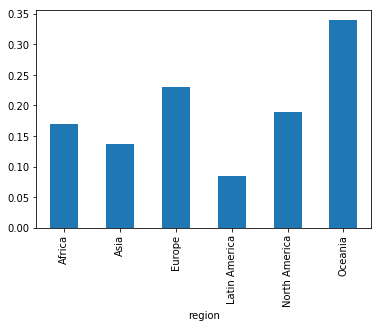

In [26]:
ratio.plot.bar()
plt.show()

### aggregation by country

In [27]:
region_inter = dataframe.groupby("country")["total inter"].mean()
region_student = dataframe.groupby("country")["total student"].mean()

ratio = region_inter / region_student
ratio

country
Argentina         0.221658
Australia         0.352189
Austria           0.309980
Belgium           0.147853
Brazil            0.033072
Canada            0.260161
Chile             0.047456
China             0.113748
Denmark           0.141960
Finland           0.088671
France            0.194806
Germany           0.164833
Hong Kong         0.310751
India             0.010501
Ireland           0.235299
Israel            0.062549
Italy             0.098726
Japan             0.087363
Malaysia          0.194168
Mexico            0.023082
Netherlands       0.232980
New Zealand       0.258215
Norway            0.126776
Russia            0.168624
Saudi Arabia      0.163742
Singapore         0.276537
South Africa      0.169703
South Korea       0.116177
Spain             0.124001
Sweden            0.170716
Switzerland       0.302396
Taiwan            0.094152
United Kingdom    0.341705
United States     0.173047
dtype: float64

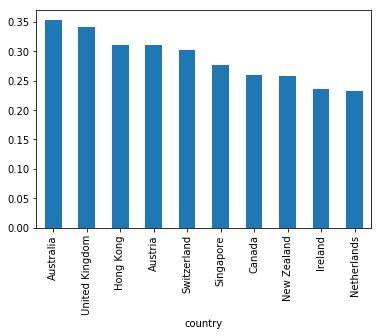

In [28]:
highest_ratio = ratio.sort_values(ascending=False).head(10)
highest_ratio.plot.bar()
plt.show()

## Exercise 2, times ranking

In [29]:
response = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')

assert response.ok

data = json.loads(response.text)
data = data["data"][:200]

In [30]:
timesFrame = pd.DataFrame(data)
timesFrame.head(5)

,aliases,location,member_level,name,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,...,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,subjects_offered,url
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,...,99.5,1,86.7,5,46 : 54,"20,409",38%,11.2,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,...,97.8,3,87.8,3,45 : 55,"18,389",35%,10.9,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,=3,30,private,99.5,10,...,97.5,4,90.3,1,31 : 69,"2,209",27%,6.5,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...
3,Stanford University,United States,11,Stanford University,467,=3,40,private,99.9,4,...,96.7,5,89.1,2,42 : 58,"15,845",22%,7.5,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university
4,Massachusetts Institute of Technology,United States,0,Massachusetts Institute of Technology,471,5,50,private,100.0,1,...,91.9,9,87.3,4,37 : 63,"11,177",34%,8.7,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/massachusetts-insti...


In [31]:
timesFrame = timesFrame[['location', 'name', 'rank', 'rank_order', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio']]
timesFrame.head(5)

,location,name,rank,rank_order,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,United Kingdom,University of Oxford,1,10,"20,409",38%,11.2
1,United Kingdom,University of Cambridge,2,20,"18,389",35%,10.9
2,United States,California Institute of Technology,=3,30,"2,209",27%,6.5
3,United States,Stanford University,=3,40,"15,845",22%,7.5
4,United States,Massachusetts Institute of Technology,5,50,"11,177",34%,8.7


In [32]:
# rename according to the first frame
timesFrame = timesFrame.rename(columns={"location":"country"})


In [33]:
# the region is not present
# we use information from the first frame to map the countries to regions
region_mapping = {}

regions = dataFrame["region"]
countries = dataFrame["country"]

for country, region in zip(countries, regions):
    region_mapping[country]=region

In [34]:
timesFrame["region"]=timesFrame["country"].apply(lambda x: region_mapping[x] if x in region_mapping else "unknown")

In [35]:
# did we miss regions ?
timesFrame[timesFrame["region"]=="unknown"]

,country,name,rank,rank_order,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,region
178,Luxembourg,University of Luxembourg,=179,1790,"4,969",57%,14.6,unknown
193,Russian Federation,Lomonosov Moscow State University,194,1940,"29,236",22%,7.3,unknown


In [36]:
timesFrame.loc[178]["region"]="Europe"
timesFrame.loc[193]["region"]="Asia"

In [37]:
timesFrame.head(5)

,country,name,rank,rank_order,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,region
0,United Kingdom,University of Oxford,1,10,"20,409",38%,11.2,Europe
1,United Kingdom,University of Cambridge,2,20,"18,389",35%,10.9,Europe
2,United States,California Institute of Technology,=3,30,"2,209",27%,6.5,North America
3,United States,Stanford University,=3,40,"15,845",22%,7.5,North America
4,United States,Massachusetts Institute of Technology,5,50,"11,177",34%,8.7,North America


In [38]:
# convert the strings to numbers
timesFrame["stats_student_staff_ratio"] = timesFrame["stats_student_staff_ratio"].apply(lambda x : float(x))
timesFrame["stats_pc_intl_students"] =  timesFrame["stats_pc_intl_students"].apply(lambda x : int(x.replace("%", ""))/100)
timesFrame["stats_number_students"] = timesFrame["stats_number_students"].apply(lambda x : int(x.replace(",", "")))

In [39]:
# convert the percentages to total amounts
timesFrame["total faculty"] =timesFrame["stats_number_students"] / timesFrame["stats_student_staff_ratio"]
timesFrame["total inter"]= timesFrame["stats_number_students"]*timesFrame["stats_pc_intl_students"]
timesFrame["inter faculty"] = timesFrame["total faculty"] * timesFrame["stats_pc_intl_students"]
timesFrame["total student"] = timesFrame["stats_number_students"]

# convert the total amounts to integers
timesFrame["total faculty"] = timesFrame["total faculty"].apply(lambda x : int(x))
timesFrame["total inter"] = timesFrame["total inter"].apply(lambda x : int(x))
timesFrame["inter faculty"] = timesFrame["inter faculty"].apply(lambda x : int(x))


timesFrame.head(5)

,country,name,rank,rank_order,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,region,total faculty,total inter,inter faculty,total student
0,United Kingdom,University of Oxford,1,10,20409,0.38,11.2,Europe,1822,7755,692,20409
1,United Kingdom,University of Cambridge,2,20,18389,0.35,10.9,Europe,1687,6436,590,18389
2,United States,California Institute of Technology,=3,30,2209,0.27,6.5,North America,339,596,91,2209
3,United States,Stanford University,=3,40,15845,0.22,7.5,North America,2112,3485,464,15845
4,United States,Massachusetts Institute of Technology,5,50,11177,0.34,8.7,North America,1284,3800,436,11177


In [40]:
# remove the original entries
del timesFrame["stats_student_staff_ratio"]
del timesFrame["stats_pc_intl_students"]
del timesFrame["stats_number_students"]

## Ratios

In [41]:
rank_by_ratio(timesFrame, "total faculty", "total student").head(5)

,country,name,rank,rank_order,region,total faculty,total inter,inter faculty,total student
105,United States,Vanderbilt University,=105,1060,North America,3639,1561,473,12011
109,Denmark,University of Copenhagen,=109,1100,Europe,7413,4255,1037,30395
12,United States,Johns Hopkins University,13,130,North America,3604,3719,865,15498
11,United States,Yale University,12,120,North America,2826,2552,593,12155
153,United States,University of Rochester,=153,1540,North America,2240,2794,649,9636


In [42]:
rank_by_ratio(timesFrame, "total inter", "total student").head(5)

,country,name,rank,rank_order,region,total faculty,total inter,inter faculty,total student
24,United Kingdom,London School of Economics and Political Science,=25,250,Europe,825,7146,585,10065
178,Luxembourg,University of Luxembourg,=179,1790,Europe,340,2832,193,4969
7,United Kingdom,Imperial College London,8,80,Europe,1390,8721,765,15857
37,Switzerland,École Polytechnique Fédérale de Lausanne,=38,380,Europe,886,5460,487,9928
102,Netherlands,Maastricht University,103,1030,Europe,929,8363,464,16727


## Aggregations and plots

In [43]:
region_inter = timesFrame.groupby("region")["total inter"].mean()
region_student = timesFrame.groupby("region")["total student"].mean()

ratio = region_inter / region_student
ratio

region
Africa           0.179976
Asia             0.152196
Europe           0.224698
North America    0.171996
Oceania          0.309745
dtype: float64

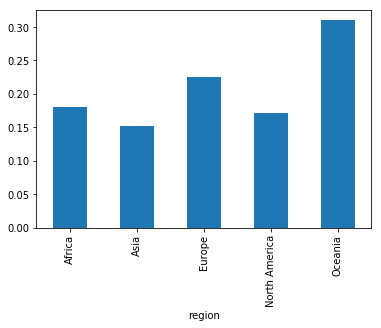

In [44]:
ratio.plot.bar()
plt.show()

In [45]:
region_inter = timesFrame.groupby("country")["total inter"].mean()
region_student = timesFrame.groupby("country")["total student"].mean()

ratio = region_inter / region_student
ratio

country
Australia             0.311979
Austria               0.259986
Belgium               0.182654
Canada                0.224145
China                 0.090106
Denmark               0.145469
Finland               0.110528
France                0.190918
Germany               0.149192
Hong Kong             0.323925
Ireland               0.269976
Italy                 0.109544
Japan                 0.090716
Luxembourg            0.569934
Netherlands           0.173033
New Zealand           0.289970
Norway                0.189975
Russian Federation    0.219969
Singapore             0.304522
South Africa          0.179976
South Korea           0.107385
Spain                 0.149698
Sweden                0.127296
Switzerland           0.303592
Taiwan                0.079980
United Kingdom        0.357189
United States         0.164370
dtype: float64

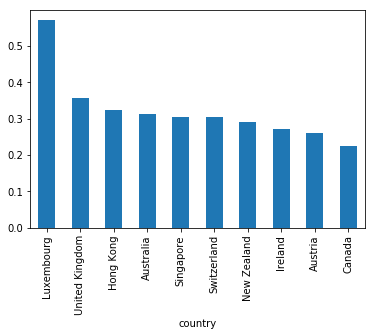

In [46]:
highest_ratio = ratio.sort_values(ascending=False).head(10)
highest_ratio.plot.bar()
plt.show()

# Merging the dataframes

In [47]:
from difflib import SequenceMatcher

In [48]:
SequenceMatcher(None, "University of Aachen", "University of Cologne").ratio()

0.7317073170731707

In [49]:
# we will rename the universities in the dataframe
renamedFrame = dataframe.copy()

In [50]:
# find the closes matches
names_a = renamedFrame["name"]
names_b = timesFrame["name"]

In [51]:
# we map every name from names_a to a numpy array
# an entry in the numpy array is the similarity with the corresponding name in names_b
ratios={name_a : np.array([SequenceMatcher(None, name_a, name_b).ratio() for name_b in names_b])
        for name_a in names_a}

In [52]:
# now we can find out the best fits
best_fits = {name_a : names_b[np.argmax(ratios[name_a])] for name_a in names_a}

In [53]:
# now replace every name in dataFrame with the matched name
renamedFrame["name"] = renamedFrame["name"].apply(lambda x : best_fits[x])

In [54]:
# now we can merge based on the name
jointFrame = renamedFrame.merge(timesFrame, on="name")

In [55]:
jointFrame.head(5)

,idx,name,rank_x,country_x,region_x,total faculty_x,inter faculty_x,total student_x,total inter_x,country_y,rank_y,rank_order,region_y,total faculty_y,total inter_y,inter faculty_y,total student_y
0,0,Massachusetts Institute of Technology,1,United States,North America,2982.0,1679.0,11067.0,3717.0,United States,5,50,North America,1284,3800,436,11177
1,1,Stanford University,2,United States,North America,4285.0,2042.0,15878.0,3611.0,United States,=3,40,North America,2112,3485,464,15845
2,2,Harvard University,3,United States,North America,4350.0,1311.0,22429.0,5266.0,United States,6,60,North America,2283,5284,593,20326
3,122,Harvard University,122,Japan,Asia,2605.0,210.0,17552.0,1347.0,United States,6,60,North America,2283,5284,593,20326
4,3,California Institute of Technology,4,United States,North America,953.0,350.0,2255.0,647.0,United States,=3,30,North America,339,596,91,2209


## There are two Harvard universities ?
Maybe the best fits aren't good enough in some cases

In [56]:
harvard_clashes=[x for x in best_fits if "harvard" in best_fits[x].lower()]
harvard_clashes

['Hokkaido University', 'Harvard University']

In [57]:
renamedFrame = dataframe.copy()

# find the closes matches
names_a = renamedFrame["name"]
names_b = timesFrame["name"]

# we map every name from names_a to a numpy array
# an entry in the numpy array is the similarity with the corresponding name in names_b
ratios={name_a : np.array([SequenceMatcher(None, name_a, name_b).ratio() for name_b in names_b])
        for name_a in names_a}

# we map every university to its best match
# but only if the match is above a threshold
threshold = 0.9
best_fits = {name_a : (names_b[np.argmax(ratios[name_a])] if np.max(ratios[name_a])>threshold else name_a) for name_a in names_a}

# now replace every name in dataFrame with the matched name
renamedFrame["name"] = renamedFrame["name"].apply(lambda x : best_fits[x])

In [58]:
# now we can merge based on the name
jointFrame = renamedFrame.merge(timesFrame, on="name")

In [59]:
jointFrame.head(5)

,idx,name,rank_x,country_x,region_x,total faculty_x,inter faculty_x,total student_x,total inter_x,country_y,rank_y,rank_order,region_y,total faculty_y,total inter_y,inter faculty_y,total student_y
0,0,Massachusetts Institute of Technology,1,United States,North America,2982.0,1679.0,11067.0,3717.0,United States,5,50,North America,1284,3800,436,11177
1,1,Stanford University,2,United States,North America,4285.0,2042.0,15878.0,3611.0,United States,=3,40,North America,2112,3485,464,15845
2,2,Harvard University,3,United States,North America,4350.0,1311.0,22429.0,5266.0,United States,6,60,North America,2283,5284,593,20326
3,4,University of Cambridge,5,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0,United Kingdom,2,20,Europe,1687,6436,590,18389
4,5,University of Oxford,6,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0,United Kingdom,1,10,Europe,1822,7755,692,20409


## Correlations in the data

In [60]:
# calculating percentages of international faculty and students
jointFrame["inter faculty_x"]=jointFrame["inter faculty_x"].astype(int)
jointFrame["total faculty_x"]=jointFrame["total faculty_x"].astype(int)
jointFrame["percentage faculty_inter_x"]=jointFrame["inter faculty_x"] / jointFrame["total faculty_x"]


jointFrame["total inter_x"]=jointFrame["total inter_x"].astype(int)
jointFrame["total student_x"]=jointFrame["total student_x"].astype(int)
jointFrame["percentage student_inter_x"]=jointFrame["total inter_x"] / jointFrame["total student_x"]

# within the data from topuniversities the international students and faculty members correlate
# but it is not a strong correlation
jointFrame["percentage student_inter_x"].corr(jointFrame["percentage faculty_inter_x"])

0.62176190294091582

In [61]:
# calculating percentages of international faculty and students
jointFrame["inter faculty_y"]=jointFrame["inter faculty_y"].astype(int)
jointFrame["total faculty_y"]=jointFrame["total faculty_y"].astype(int)
jointFrame["percentage faculty_inter_y"]=jointFrame["inter faculty_y"] / jointFrame["total faculty_y"]


jointFrame["total inter_y"]=jointFrame["total inter_y"].astype(int)
jointFrame["total student_y"]=jointFrame["total student_y"].astype(int)
jointFrame["percentage student_inter_y"]=jointFrame["total inter_y"] / jointFrame["total student_y"]

# within the times data, the correlation is extremely strong
# this is because in the times data there is no information on international faculty
# we estimated the percentage of the faculty based on the percentage of international students
# so this correlation was programmed into the data by us
jointFrame["percentage student_inter_y"].corr(jointFrame["percentage faculty_inter_y"])

0.99997194163568015

## Looking for a stronger correlation

In [62]:
# do the ranks correlate between the two frames
jointFrame["rank_x"]=jointFrame["rank_x"].astype(int)
jointFrame["rank_order"]=jointFrame["rank_order"].astype(int)


# yes, but not as strongly as I would have expected
jointFrame["rank_x"].corr(jointFrame["rank_order"])

0.70786287396636216

In [63]:
# do international students and ranks correlate ?
# let's take the mean of the columns for rank and international percentages

jointFrame["rank_order"]=jointFrame["rank_order"].astype(int)
jointFrame["rank_order_rescaled"] = jointFrame["rank_order"]/10
mean_rank = jointFrame[["rank_x", "rank_order_rescaled"]].mean(axis=1)

mean_international = jointFrame[["percentage faculty_inter_x", "percentage student_inter_x",
                                 "percentage faculty_inter_y", "percentage student_inter_y"]].mean(axis=1)

# that is unexpected
# the rank goes down with the number of international students
# the correlation is very weak
mean_rank.corr(mean_international)

-0.25048219411388095

In [64]:
# does the staff ration correlate with the rank
# do international students and ranks correlate ?
# let's take the mean of the columns for rank and international percentages

jointFrame["staff ratio_x"]=jointFrame["total faculty_x"] / jointFrame["total student_x"]
jointFrame["staff ratio_y"]=jointFrame["total faculty_y"] / jointFrame["total student_y"]
           
mean_ratio = jointFrame[["staff ratio_x", "staff ratio_y"]].mean(axis=1)
           
# again: an unexpected weak negative correlation
mean_rank.corr(mean_ratio)

-0.28849206291329393